In [1]:
# ==========================================
# 0. 环境设置与配置 (Configuration)
# ==========================================
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import seaborn as sns

plt.rcParams.update({
    "font.family": "monospace",
    "font.monospace": ["Consolas"],
    "axes.unicode_minus": False
})

# 下载并应用主题样式
import os
if not os.path.exists('rose-pine-dawn.mplstyle'):
    !wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -O rose-pine-dawn.mplstyle
plt.style.use('rose-pine-dawn.mplstyle')

# 检查是否有GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 更新后的全局配置参数
CONFIG = {
    "model_ckpt": "distilbert-base-uncased",
    "batch_size": 64,
    "learning_rate": 3e-5,   # 更新：从2e-5改为3e-5
    "num_epochs": 2,
    "weight_decay": 0.01,
    "eval_strategy": "epoch",
}

print("Updated Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

--2025-12-16 06:07:47--  https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40905 (40K) [text/plain]
Saving to: ‘rose-pine-dawn.mplstyle’

rose-pine-dawn.mpls 100%[===================>]  39.95K  --.-KB/s    in 0.001s  

2025-12-16 06:07:47 (26.9 MB/s) - ‘rose-pine-dawn.mplstyle’ saved [40905/40905]

Using device: cuda
Updated Configuration:
  model_ckpt: distilbert-base-uncased
  batch_size: 64
  learning_rate: 3e-05
  num_epochs: 2
  weight_decay: 0.01
  eval_strategy: epoch


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset Structure: DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
Sample data: {'text': 'i didnt feel humiliated', 'label': 0}
                                                text  label label_name
0                            i didnt feel humiliated      0    sadness
1  i can go from feeling so hopeless to so damned...      0    sadness
2   im grabbing a minute to post i feel greedy wrong      3      anger
3  i am ever feeling nostalgic about the fireplac...      2       love
4                               i am feeling grouchy      3      anger


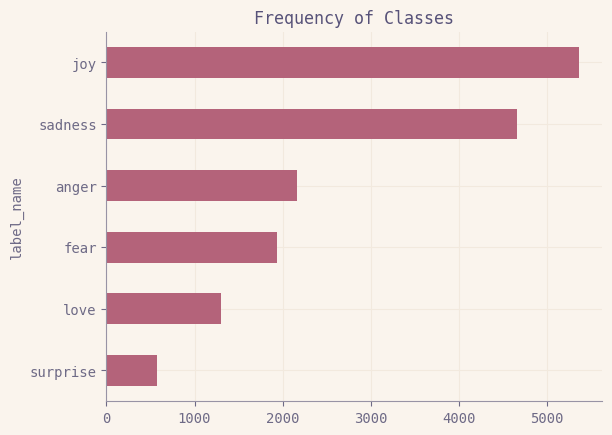

In [2]:
# ==========================================
# 1. 数据加载 (Data Loading)
# ==========================================
# 加载情感分类数据集
dataset = load_dataset("emotion")

# 查看数据结构
print("Dataset Structure:", dataset)
train_ds = dataset["train"]
print(f"Sample data: {train_ds[0]}")

# 将数据转换为Pandas DataFrame以便分析 (可选)
dataset.set_format(type="pandas")
df = dataset["train"][:]

# 添加标签名称列以便分析
label_names = dataset["train"].features["label"].names
df["label_name"] = df["label"].apply(lambda x: label_names[x])

print(df.head())


def plot_label_distribution(df):
    df["label_name"].value_counts(ascending=True).plot.barh()
    plt.title("Frequency of Classes")
    plt.show()


plot_label_distribution(df)
dataset.reset_format() # 恢复为HuggingFace格式

In [3]:
# ==========================================
# 2. 基础任务: 字符级 Tokenization
# ==========================================
text_sample = "Tokenizing text is a core task of NLP."

# 创建 token2idx 字典
token2idx = {}

# 获取数据集中所有唯一的字符并排序
unique_chars = sorted(set("".join(dataset["train"]["text"])))

# 创建字符到索引的映射字典
token2idx = {ch: idx for idx, ch in enumerate(unique_chars)}

#检查词汇表大小
print(f"Task 1 Check - Vocab size: {len(token2idx)}")

Task 1 Check - Vocab size: 27


In [4]:
# ==========================================
# 3. 使用预训练模型的分词器 (Pre-trained Tokenizer)
# ==========================================
# 加载 DistilBERT 的分词器
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_ckpt"])

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# 对整个数据集进行分词处理
print("Tokenizing dataset...")
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)
print("Tokenization complete.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing dataset...


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenization complete.


In [5]:
# ==========================================
# 4. 特征提取 (Feature Extraction)
# ==========================================
# 加载预训练模型 (不带分类头，仅用于提取 hidden states)
model = AutoModel.from_pretrained(CONFIG["model_ckpt"]).to(device)

def extract_hidden_states(batch):
    # 将输入数据转为 Tensor 并移动到 GPU/CPU
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        # 获取模型的隐藏状态输出
        last_hidden_state = model(**inputs).last_hidden_state
        # 提取 [CLS] token 的向量 (索引为 0)
        cls_vector = last_hidden_state[:, 0].cpu().numpy()
    return {"hidden_state": cls_vector}

# 转换格式为 torch 以便提取特征
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# 执行提取 (可能需要几分钟)
print("Extracting hidden states...")
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)
print("Extraction complete.")

# 准备 Scikit-Learn 的输入数据
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Extracting hidden states...


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Extraction complete.


In [6]:
# ==========================================
# 5. 传统机器学习分类 (Scikit-Learn Baselines)
# ==========================================
from tqdm import tqdm
import time

# 定义训练函数
def train_with_progress(clf, X_train, y_train, name, color='cyan'):
    print(f"   正在训练 {name}...")
    with tqdm(total=1, desc=f"{name}训练", unit="个", ncols=100, colour=color) as pbar:
        start_time = time.time()
        clf.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        pbar.update(1)
        pbar.set_postfix({'用时': f'{elapsed_time:.2f}s'})
    return clf

# 1. Logistic Regression
print("\n--- Training Logistic Regression ---")
lr_clf = LogisticRegression(max_iter=3000, random_state=42)
lr_clf = train_with_progress(lr_clf, X_train, y_train, "Logistic Regression", "green")
lr_preds = lr_clf.predict(X_valid)
lr_accuracy = accuracy_score(y_valid, lr_preds)
print(f"   Logistic Regression Accuracy: {lr_accuracy:.4f}")

# 2. SVM
print("\n--- Training SVM ---")
svm_clf = SVC(kernel='rbf', random_state=42)
svm_clf = train_with_progress(svm_clf, X_train, y_train, "SVM", "blue")
svm_preds = svm_clf.predict(X_valid)
svm_accuracy = accuracy_score(y_valid, svm_preds)
print(f"   SVM Accuracy: {svm_accuracy:.4f}")

# 3. Random Forest
print("\n--- Training Random Forest ---")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf = train_with_progress(rf_clf, X_train, y_train, "Random Forest", "magenta")
rf_preds = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid, rf_preds)
print(f"   Random Forest Accuracy: {rf_accuracy:.4f}")

# 4. 模型效果对比总结
print("\n=== 传统机器学习模型效果对比 ===")
print(f"Logistic Regression: {lr_accuracy:.4f}")
print(f"SVM:                {svm_accuracy:.4f}")
print(f"Random Forest:      {rf_accuracy:.4f}")


--- Training Logistic Regression ---
   正在训练 Logistic Regression...


Logistic Regression训练: 100%|█████████████████████████| 1/1 [02:18<00:00, 138.94s/个, 用时=138.93s]


   Logistic Regression Accuracy: 0.6340

--- Training SVM ---
   正在训练 SVM...


SVM训练: 100%|█████████████████████████████████████████| 1/1 [01:45<00:00, 105.06s/个, 用时=105.05s]


   SVM Accuracy: 0.5830

--- Training Random Forest ---
   正在训练 Random Forest...


Random Forest训练: 100%|█████████████████████████████████| 1/1 [01:08<00:00, 68.97s/个, 用时=68.97s]

   Random Forest Accuracy: 0.5205

=== 传统机器学习模型效果对比 ===
Logistic Regression: 0.6340
SVM:                0.5830
Random Forest:      0.5205


In [7]:
# ==========================================
# 6. 微调 Transformer (Fine-tuning)
# ==========================================
# 加载带有分类头的模型
num_labels = 6 # emotion 数据集有 6 类
model_ft = AutoModelForSequenceClassification.from_pretrained(
    CONFIG["model_ckpt"], num_labels=num_labels
).to(device)

# 定义评估指标
def compute_metrics(




    pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

training_args = TrainingArguments(
    output_dir=f"{CONFIG['model_ckpt']}-finetuned-emotion",
    num_train_epochs=CONFIG["num_epochs"],
    learning_rate=CONFIG["learning_rate"],
    per_device_train_batch_size=CONFIG["batch_size"],
    per_device_eval_batch_size=CONFIG["batch_size"],
    weight_decay=CONFIG["weight_decay"],
    eval_strategy=CONFIG["eval_strategy"],
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="no",  # 不保存模型以节省时间
)

trainer = Trainer(
    model=model_ft,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer
)

print("\n--- Starting Fine-tuning ---")
trainer.train()

# 评估微调后的模型
preds_output = trainer.predict(dataset_encoded["validation"])
bert_accuracy = preds_output.metrics['test_accuracy']
print(f"Fine-tuned BERT Accuracy: {bert_accuracy:.4f}")

# 获取BERT的预测结果
bert_preds = np.argmax(preds_output.predictions, axis=-1)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-284567305.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



--- Starting Fine-tuning ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy
1,0.389200,0.213602,0.921500
2,0.175400,0.163874,0.935500


Fine-tuned BERT Accuracy: 0.9355



=== 开始可视化分析 ===


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


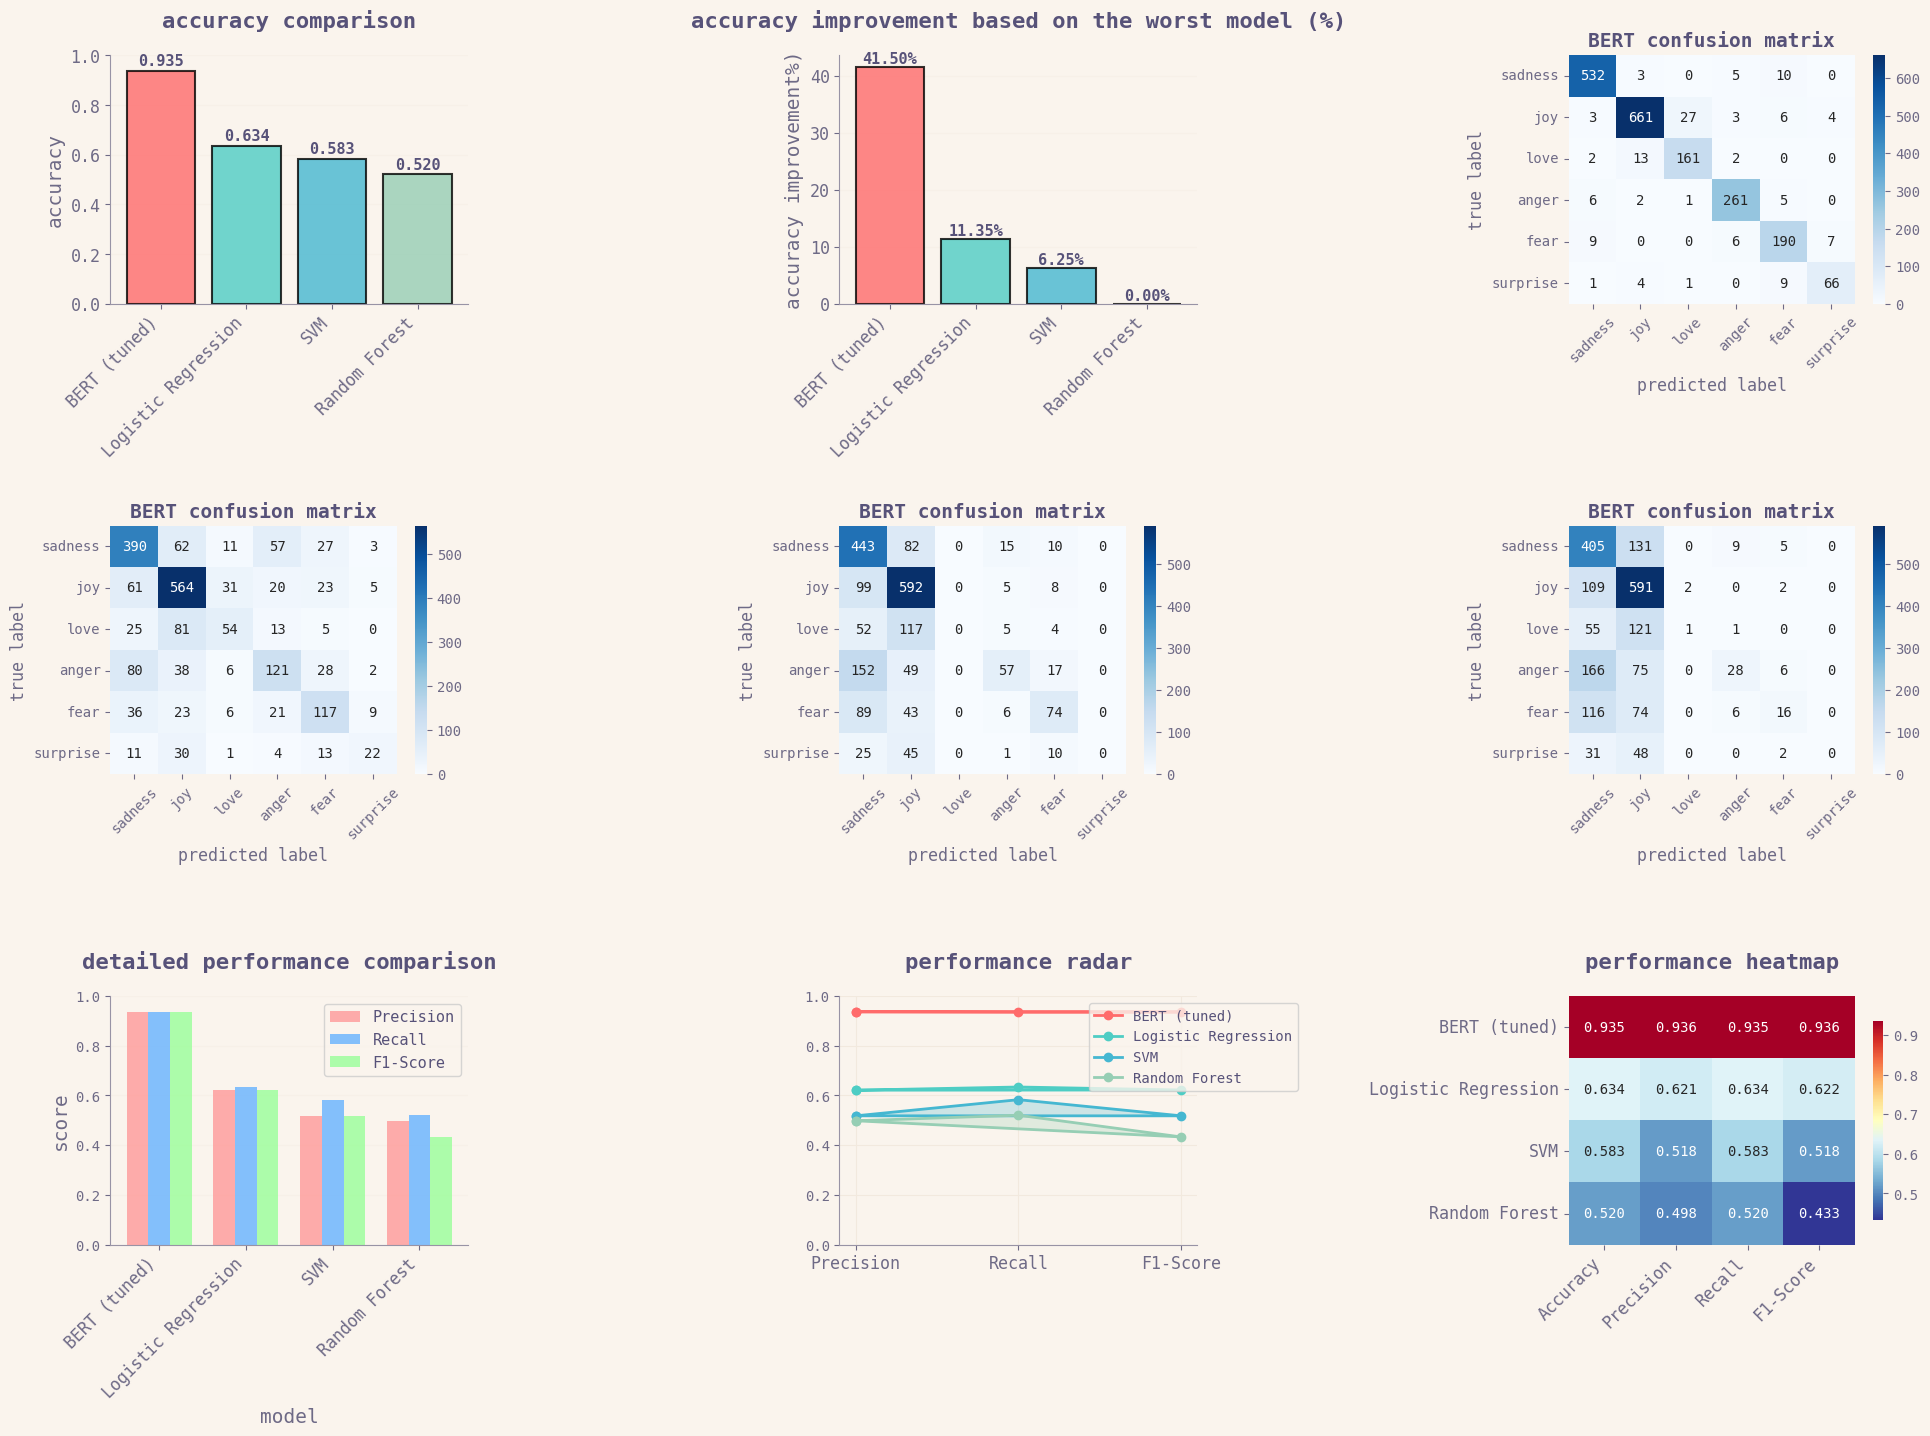


详细分类报告对比

BERT (tuned):
--------------------------------------------------
              precision    recall  f1-score   support

     sadness     0.9620    0.9673    0.9646       550
         joy     0.9678    0.9389    0.9531       704
        love     0.8474    0.9045    0.8750       178
       anger     0.9422    0.9491    0.9457       275
        fear     0.8636    0.8962    0.8796       212
    surprise     0.8571    0.8148    0.8354        81

    accuracy                         0.9355      2000
   macro avg     0.9067    0.9118    0.9089      2000
weighted avg     0.9365    0.9355    0.9358      2000


Logistic Regression:
--------------------------------------------------
              precision    recall  f1-score   support

     sadness     0.6468    0.7091    0.6765       550
         joy     0.7068    0.8011    0.7510       704
        love     0.4954    0.3034    0.3763       178
       anger     0.5127    0.4400    0.4736       275
        fear     0.5493    0.5519    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

In [14]:
# ==========================================
# 7. 可视化分析：训练后BERT与传统机器学习模型的分类性能差异
# ==========================================

print("\n=== 开始可视化分析 ===")

# 准备所有模型的预测结果和准确率
models_data = {
    'BERT (tuned)': {
        'accuracy': bert_accuracy,
        'predictions': bert_preds
    },
    'Logistic Regression': {
        'accuracy': lr_accuracy,
        'predictions': lr_preds
    },
    'SVM': {
        'accuracy': svm_accuracy,
        'predictions': svm_preds
    },
    'Random Forest': {
        'accuracy': rf_accuracy,
        'predictions': rf_preds
    }
}

# 创建大型综合可视化图表
plt.figure(figsize=(20, 15))

# 1. 准确率对比柱状图
plt.subplot(3, 3, 1)
model_names = list(models_data.keys())
accuracies = [models_data[name]['accuracy'] for name in model_names]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

bars = plt.bar(model_names, accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.title('accuracy comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('accuracy', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# 在柱子上添加数值标签
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.grid(axis='y', alpha=0.3)

# 2. 准确率提升幅度对比 (以最差的模型为基准)
plt.subplot(3, 3, 2)
baseline_acc = min(accuracies)
improvements = [(acc - baseline_acc) * 100 for acc in accuracies]

bars = plt.bar(model_names, improvements, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.title('accuracy improvement based on the worst model (%)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('accuracy improvement%)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

for bar, imp in zip(bars, improvements):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{imp:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.grid(axis='y', alpha=0.3)

# 3. 各模型混淆矩阵对比
from sklearn.metrics import confusion_matrix

for idx, (model_name, data) in enumerate(models_data.items()):
    if idx >= 4:  # 只显示前4个模型
        break
    plt.subplot(3, 3, 3 + idx)
    cm = confusion_matrix(y_valid, data['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_names, yticklabels=label_names)
    plt.title('BERT confusion matrix', fontsize=14, fontweight='bold')
    plt.xlabel('predicted label', fontsize=12)
    plt.ylabel('true label', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

# 7-9. 详细性能指标对比 (Precision, Recall, F1-score)
plt.subplot(3, 3, 7)
bert_precision, bert_recall, bert_f1, _ = precision_recall_fscore_support(
    y_valid, bert_preds, average='weighted')
lr_precision, lr_recall, lr_f1, _ = precision_recall_fscore_support(
    y_valid, lr_preds, average='weighted')
svm_precision, svm_recall, svm_f1, _ = precision_recall_fscore_support(
    y_valid, svm_preds, average='weighted')
rf_precision, rf_recall, rf_f1, _ = precision_recall_fscore_support(
    y_valid, rf_preds, average='weighted')

metrics_data = {
    'Precision': [bert_precision, lr_precision, svm_precision, rf_precision],
    'Recall': [bert_recall, lr_recall, svm_recall, rf_recall],
    'F1-Score': [bert_f1, lr_f1, svm_f1, rf_f1]
}

x = np.arange(len(model_names))
width = 0.25

plt.bar(x - width, metrics_data['Precision'], width, label='Precision', alpha=0.8, color='#FF9999')
plt.bar(x, metrics_data['Recall'], width, label='Recall', alpha=0.8, color='#66B2FF')
plt.bar(x + width, metrics_data['F1-Score'], width, label='F1-Score', alpha=0.8, color='#99FF99')

plt.title('detailed performance comparison', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('score', fontsize=14)
plt.xlabel('model', fontsize=14)
plt.xticks(x, model_names, rotation=45, ha='right', fontsize=12)
plt.legend(fontsize=11)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)

# 8. 模型性能雷达图
plt.subplot(3, 3, 8)
from math import pi

# 计算角度
angles = [n / float(len(metrics_data)) * 2 * pi for n in range(len(metrics_data))]
angles += angles[:1]  # 闭合图形

# 为每个模型绘制雷达图
for idx, (model_name, color) in enumerate(zip(model_names, colors)):
    values = [metrics_data[metric][idx] for metric in metrics_data.keys()]
    values += values[:1]  # 闭合图形

    plt.plot(angles, values, 'o-', linewidth=2, label=model_name, color=color)
    plt.fill(angles, values, alpha=0.25, color=color)

plt.xticks(angles[:-1], metrics_data.keys(), fontsize=12)
plt.ylim(0, 1)
plt.title('performance radar', fontsize=16, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)
plt.grid(True)

# 9. 性能差异热力图
plt.subplot(3, 3, 9)
performance_matrix = np.array([
    [bert_accuracy, bert_precision, bert_recall, bert_f1],
    [lr_accuracy, lr_precision, lr_recall, lr_f1],
    [svm_accuracy, svm_precision, svm_recall, svm_f1],
    [rf_accuracy, rf_precision, rf_recall, rf_f1]
])

sns.heatmap(performance_matrix,
            annot=True, fmt='.3f', cmap='RdYlBu_r',
            xticklabels=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
            yticklabels=model_names,
            cbar_kws={'shrink': 0.8})
plt.title('performance heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()

# 打印详细的分类报告
print("\n" + "="*80)
print("详细分类报告对比")
print("="*80)

for model_name, data in models_data.items():
    print(f"\n{model_name}:")
    print("-" * 50)
    print(classification_report(y_valid, data['predictions'],
                              target_names=label_names,
                              digits=4))

# 计算并显示性能差异统计
print("\n" + "="*80)
print("性能差异统计分析")
print("="*80)
print(f"\nBERT vs 传统机器学习模型准确率对比:")
print(f"  BERT vs Logistic Regression: +{(bert_accuracy - lr_accuracy)*100:.2f}%")
print(f"  BERT vs SVM: +{(bert_accuracy - svm_accuracy)*100:.2f}%")
print(f"  BERT vs Random Forest: +{(bert_accuracy - rf_accuracy)*100:.2f}%")

print(f"\n最佳传统模型 vs BERT:")
best_traditional_acc = max(lr_accuracy, svm_accuracy, rf_accuracy)
best_traditional_name = max(models_data.items(),
                           key=lambda x: x[1]['accuracy'] if 'Logistic' in x[0] or 'SVM' in x[0] or 'Random' in x[0] else 0)[0]
print(f"  {best_traditional_name}: {best_traditional_acc:.4f}")
print(f"  BERT: {bert_accuracy:.4f}")
print(f"  提升幅度: +{(bert_accuracy - best_traditional_acc)*100:.2f}%")

In [9]:
# ==========================================
# 8. 错误分析 (Error Analysis)
# ==========================================
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 将数据输入模型计算 loss
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model_ft(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

# 获取每个样本的 loss
print("\n--- Performing Error Analysis ---")
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
dataset_with_loss = dataset_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

# 将结果转为 DataFrame 并按 loss 降序排列
dataset_with_loss.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = dataset_with_loss[:][cols]
df_test["label"] = df_test["label"].apply(lambda x: dataset["train"].features["label"].int2str(x))
df_test["predicted_label"] = df_test["predicted_label"].apply(lambda x: dataset["train"].features["label"].int2str(x))

print("Top 5 worst predictions (Highest Loss):")
print(df_test.sort_values("loss", ascending=False).head(5))


--- Performing Error Analysis ---


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Top 5 worst predictions (Highest Loss):
                                                   text     label  \
1963  i called myself pro life and voted for perry w...       joy   
1950  i as representative of everything thats wrong ...  surprise   
318   i felt ashamed of these feelings and was scare...      fear   
1870  i guess i feel betrayed because i admired him ...       joy   
882   i feel badly about reneging on my commitment t...      love   

     predicted_label      loss  
1963         sadness  5.872459  
1950         sadness  5.735368  
318          sadness  5.374527  
1870         sadness  5.341645  
882          sadness  5.331951  



=== BERT错误分析可视化 ===


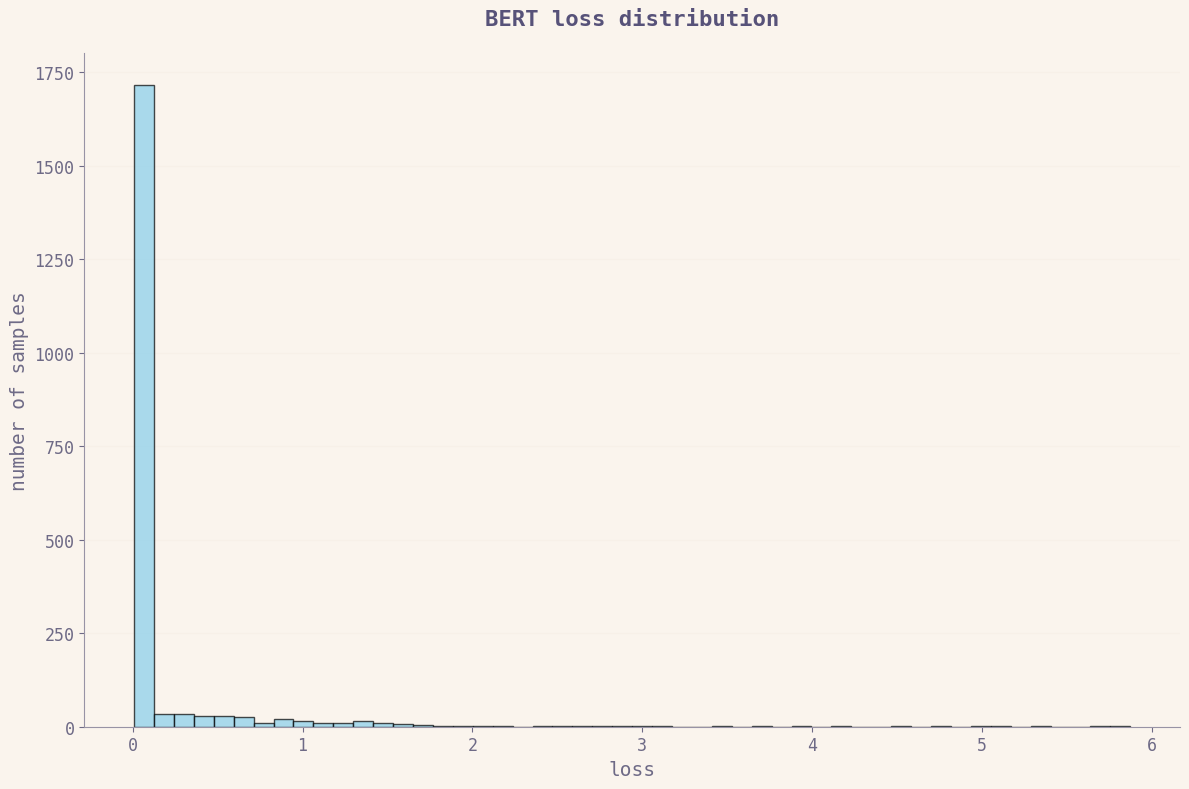

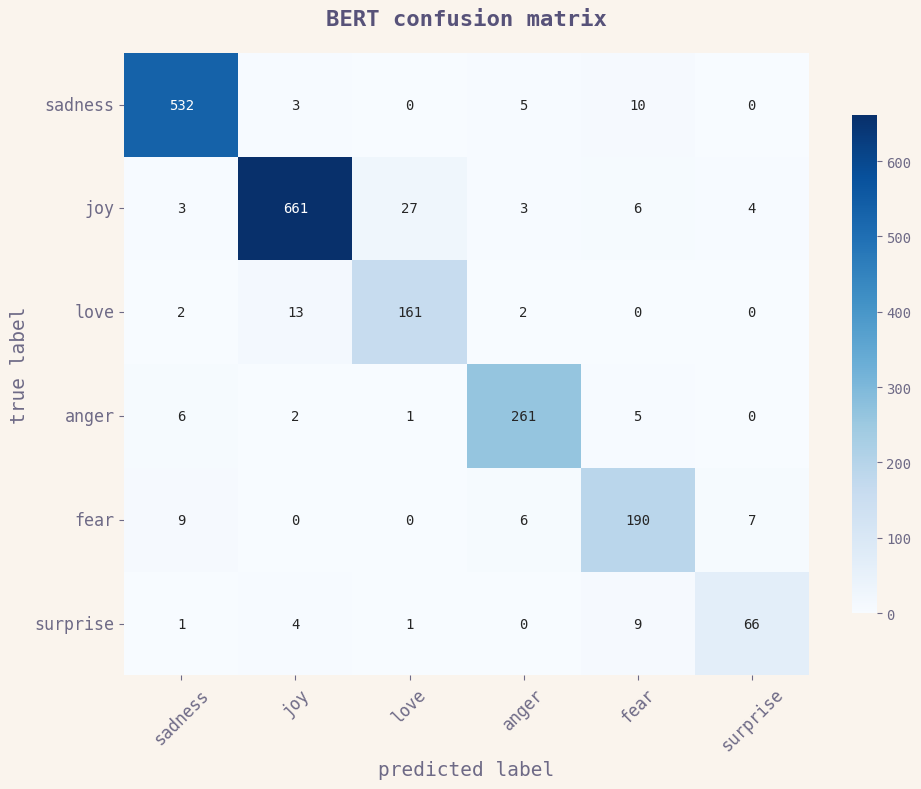

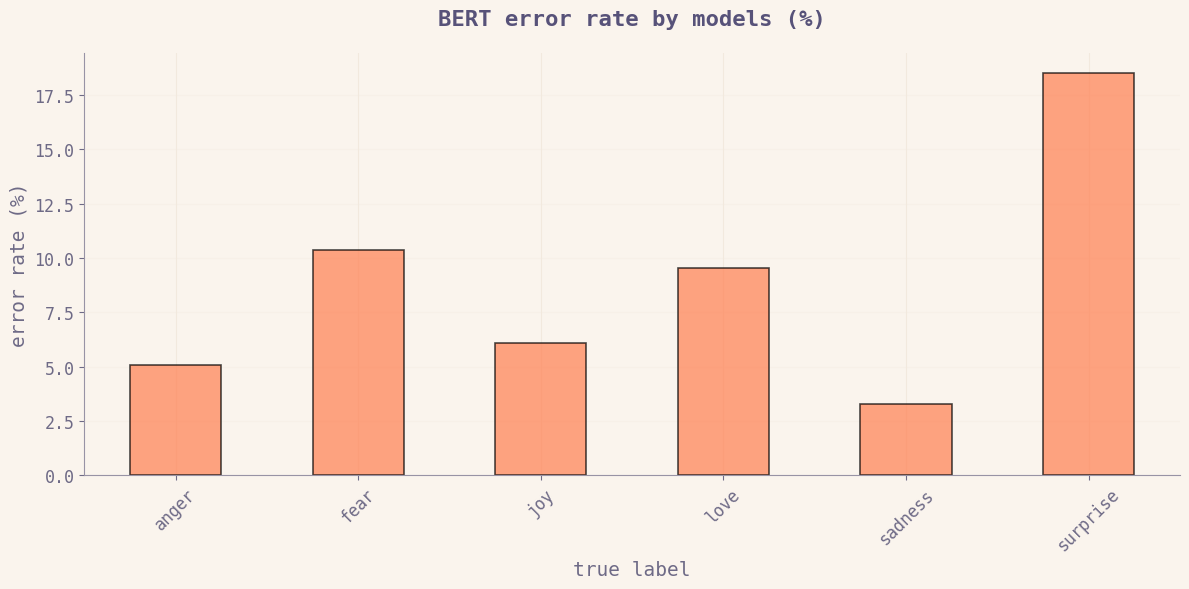

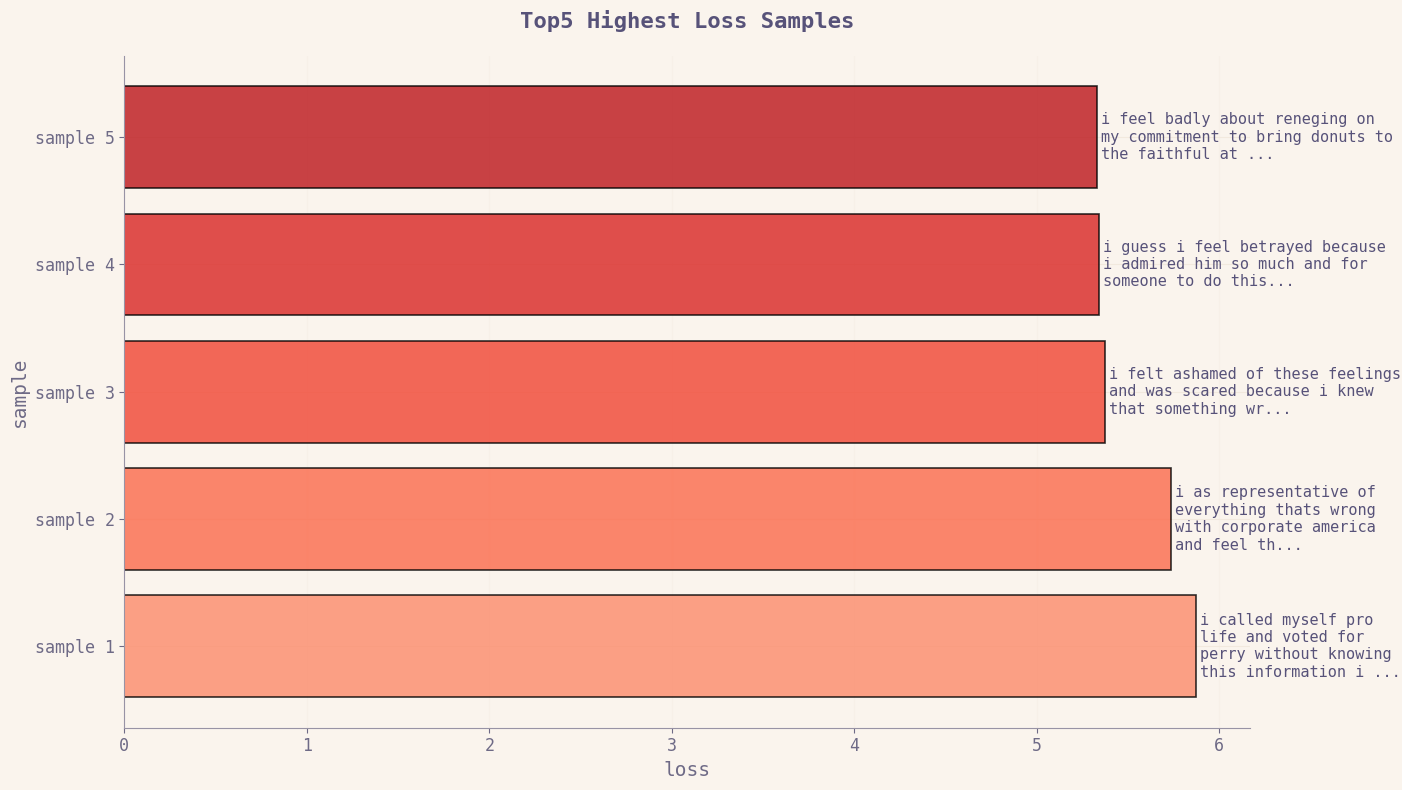


=== BERT详细错误分析 ===
总样本数: 2000
错误分类样本数: 129
整体错误率: 6.45%


In [11]:
# ==========================================
# 9. 错误分析可视化
# ==========================================
print("\n=== BERT错误分析可视化 ===")

# 1. 损失值分布直方图
plt.figure(figsize=(12, 8))
plt.hist(df_test["loss"], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('BERT loss distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('loss', fontsize=14)
plt.ylabel('number of samples', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 2. BERT混淆矩阵
plt.figure(figsize=(10, 8))
cm_bert = confusion_matrix(y_valid, bert_preds)
label_names = dataset["train"].features["label"].names
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': 0.8},
            xticklabels=label_names, yticklabels=label_names)
plt.title('BERT confusion matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('predicted label', fontsize=14)
plt.ylabel('true label', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

# 3. 各类别错误率分析
plt.figure(figsize=(12, 6))
error_by_class = df_test[df_test["label"] != df_test["predicted_label"]].groupby("label").size()
total_by_class = df_test.groupby("label").size()
error_rates = (error_by_class / total_by_class * 100).fillna(0)

error_rates.plot(kind='bar', color='coral', alpha=0.7, edgecolor='black', linewidth=1.2)
plt.title('BERT error rate by models (%)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('true label', fontsize=14)
plt.ylabel('error rate (%)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. 损失值最高的样本 (Top 5)
plt.figure(figsize=(14, 8))
top_losses = df_test.sort_values("loss", ascending=False).head(5)
y_pos = range(len(top_losses))

# 创建水平条形图
colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(top_losses)))
bars = plt.barh(y_pos, top_losses["loss"], color=colors, alpha=0.8, edgecolor='black', linewidth=1.2)

# 添加文本标签（完整的句子）
for i, (idx, row) in enumerate(top_losses.iterrows()):
    # 显示完整文本，但在适当位置换行
    text = row["text"]
    if len(text) > 80:
        text = text[:80] + "..."
    plt.text(row["loss"] + 0.02, i, text, va='center', fontsize=11, wrap=True)

plt.title('Top5 Highest Loss Samples', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('loss', fontsize=14)
plt.ylabel('sample', fontsize=14)
plt.yticks(y_pos, [f'sample {i+1}' for i in range(len(top_losses))], fontsize=12)
plt.xticks(fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 打印详细分析结果
print("\n=== BERT详细错误分析 ===")
print(f"总样本数: {len(df_test)}")
print(f"错误分类样本数: {len(df_test[df_test['label'] != df_test['predicted_label']])}")
print(f"整体错误率: {len(df_test[df_test['label'] != df_test['predicted_label']]) / len(df_test) * 100:.2f}%")

In [15]:
# %%
# ==========================================
# 8. 对抗样本生成 (Adversarial Examples)
# ==========================================

# ------------------------------------------------------------------
# TODO: 任务 6 - 生成 5 个对抗样本
# ------------------------------------------------------------------
# 五类对抗样本样例

print("\n--- Testing Custom/Adversarial Examples ---")
custom_tweets = [
    # 1. 反语/讽刺 (Sarcasm) - 正面词汇表达负面情感
    "I absolutely love waiting in line for three hours in the rain. Best day ever.",

    # 2. 转折句 (Contrast/But-clauses) - 前褒后贬结构
    "The plot was promising and the actors were great, but I fell asleep in the first 20 minutes.",

    # 3. 双重否定/含蓄表达 (Double Negation) - 复杂逻辑结构
    "I can't say that I didn't dislike the ending.",

    # 4. 极度口语化/俚语 (Slang/Colloquialism) - 俚语含义与字面相反
    "This movie is sick! I screamed!",

    # 5. 比较级陷阱 (Comparative Trap) - 正面词汇但对比标准极低
    "It was better than getting a root canal, I guess."
]

# 预测这些对抗样本的情感标签
# 直接使用模型进行预测
inputs = tokenizer(custom_tweets, padding=True, truncation=True, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model_ft(**inputs)
    logits = outputs.logits
pred_labels = torch.argmax(logits, dim=-1).cpu().numpy()

labels_names = dataset["train"].features["label"].names
for i, (tweet, label_idx) in enumerate(zip(custom_tweets, pred_labels)):
    categories = ["反语/讽刺", "转折句", "双重否定", "俚语", "比较级陷阱"]
    print(f"\n{i+1}. {categories[i]}")
    print(f"   句子: {tweet}")
    print(f"   预测: {labels_names[label_idx]}")


--- Testing Custom/Adversarial Examples ---

1. 反语/讽刺
   句子: I absolutely love waiting in line for three hours in the rain. Best day ever.
   预测: joy

2. 转折句
   句子: The plot was promising and the actors were great, but I fell asleep in the first 20 minutes.
   预测: joy

3. 双重否定
   句子: I can't say that I didn't dislike the ending.
   预测: anger

4. 俚语
   句子: This movie is sick! I screamed!
   预测: anger

5. 比较级陷阱
   句子: It was better than getting a root canal, I guess.
   预测: joy
